## Import the libraries

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Import the dataset

In [125]:
dataset_filepath = '/Users/davronabdukhakimov/Desktop/RealEstate_California.csv'
raw_dataset = pd.read_csv(dataset_filepath)

raw_dataset['date_posted'] = pd.to_datetime(raw_dataset['datePostedString'],format='%Y-%m-%d')

## Dealing with missing values

### Drop unnecessary columns

In [126]:
columns_to_drop = ['Unnamed: 0','cityId','id','stateId','currency','countyId','state','country','description','time','datePostedString','hasBadGeocode','is_bankOwned','is_forAuction','lotAreaUnits']
clean_dataset = raw_dataset.drop(columns_to_drop,axis = 1)

### Drop rows with nan values, duplicates and rows with event type of rent

In [127]:
clean_dataset.dropna(inplace=True)
clean_dataset.drop_duplicates(inplace=True)
clean_dataset = clean_dataset[clean_dataset['event'] != 'Listed for rent']

In [128]:
clean_dataset[clean_dataset['livingAreaValue'] == clean_dataset['buildingArea']].shape

(11200, 25)

### Extract season from date_posted column

In [129]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'
    
clean_dataset['season_posted'] = clean_dataset['date_posted'].apply(get_season)
clean_dataset.drop('date_posted',axis=1,inplace=True)
clean_dataset.head()

,event,price,pricePerSquareFoot,city,yearBuilt,streetAddress,zipcode,longitude,latitude,livingArea,...,garageSpaces,hasGarage,levels,pool,spa,isNewConstruction,hasPetsAllowed,homeType,county,season_posted
0,Listed for sale,145000.0,0.0,Gold Run,0,0 Moody Ridge Rd,95717.0,-120.834473,39.167866,0.0,...,0.0,0,0,0,0,0,0,LOT,Placer County,winter
1,Listed for sale,675000.0,404.0,Pinole,1958,1476 Belden Ct,94564.0,-122.300613,38.001213,1671.0,...,2.0,1,One Story,0,0,0,0,SINGLE_FAMILY,Contra Costa County,summer
2,Listed for sale,649000.0,459.0,Pinole,1959,3540 Savage Ave,94564.0,-122.271362,37.982040,1414.0,...,2.0,1,One Story,0,0,0,0,SINGLE_FAMILY,Contra Costa County,summer
3,Listed for sale,599000.0,448.0,Pinole,1908,2391 Plum St,94564.0,-122.289230,38.004395,1336.0,...,1.0,1,Two Story,0,1,0,0,SINGLE_FAMILY,Contra Costa County,summer
4,Listed for sale,299000.0,0.0,Pinole,0,2693 Appian Way,94564.0,-122.298439,37.986309,0.0,...,0.0,0,0,0,0,0,0,LOT,Contra Costa County,summer


### Extract street name from streetAddress column

In [130]:
split_address = clean_dataset['streetAddress'].str.split(' ',n=1,expand=True)
clean_dataset = clean_dataset[split_address[1].notna()]
clean_dataset = clean_dataset[split_address[0].str.isdigit()]
clean_dataset['street_name'] = split_address[1]
clean_dataset.drop('streetAddress',axis = 1,inplace=True)

/var/folders/r1/m92fhd0n5mq0_bh6sg3_pnlh0000gn/T/ipykernel_76939/2322718560.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clean_dataset = clean_dataset[split_address[0].str.isdigit()]


### Drop livingArea since the column contains the same values as livingAreaValue column

In [131]:
clean_dataset[clean_dataset['livingArea'] != clean_dataset['livingAreaValue']]
clean_dataset.drop('livingArea',axis=1,inplace=True)

### Drop hasGarage column since garageSpaces column is more informative

In [132]:
clean_dataset.drop('hasGarage',axis=1,inplace=True)

### Split levels column into 2 columns

In [133]:
zero_level = ['0']
one_level = ['One','One Story','One Story-One','One-Two','1','One-Multi/Split','Other-One','One-Three Or More',
             'One Story-Two','One Story-Three Or More','Multi/Split-One','One-Two-Three Or More','One-Two-Multi/Split']
two_level = ['Two','Two Story','Two Story-Two','2','Two-Multi/Split','Multi/Split-Two','Two-Three Or More','Two Story-One',
             'Two Story-Three Or More','Two-Three Or More-Multi/Split','Two-One']
three_level_more = ['Three Or More','Three or More Stories','Tri-Level','Three or More Stories-Three Or More',
                    'Three Or More-Multi/Split','3','Three','Three or More Stories-One','Three or More Stories-Two',
                   'Four','Tri-Level-Three Or More','Multi/Split-Three Or More','Multi/Split-Tri-Level','4+','Five or More',
                    'Three Or More-Split Level','Tri-Level-Two','Three Or More-Two','Three or More Stories-One-Two']


total = zero_level
total.extend(one_level)
total.extend(two_level)
total.extend(three_level_more)
missing_type = [val for val in clean_dataset['levels'].unique() if val not in total]

def get_level(level):
    if level in one_level:
        if 'split' in level.lower() or 'multi' in level.lower():
            return ['one', 1]
        else:
            return ['one', 0]
    elif level in two_level:
        if 'split' in level.lower() or 'multi' in level.lower():
            return ['two', 1]
        else:
            return ['two', 0]
    elif level in three_level_more:
        if 'split' in level.lower() or 'multi' in level.lower():
            return ['three+', 1]
        else:
            return ['three+', 0]
    else:
        if 'split' in level.lower() or 'multi' in level.lower():
            return ['zero', 1]
        else:
            return ['zero', 0]

clean_dataset[['level','multi/split']] = clean_dataset['levels'].apply(lambda x: pd.Series(get_level(x)))
clean_dataset.drop('levels',axis=1,inplace=True)

### Drop rows with homeType of LOT since we don't have their area (can be extracted from description column)

In [134]:
columns_to_show = [
        'event', 'price', 'pricePerSquareFoot', 'yearBuilt',
        'livingAreaValue', 'bathrooms', 'bedrooms',
        'buildingArea', 'parking', 'garageSpaces', 'pool', 'spa',
        'isNewConstruction', 'hasPetsAllowed', 'homeType',
        'level', 'multi/split'
]
clean_dataset[clean_dataset['homeType'] == 'LOT'][columns_to_show]['livingAreaValue'].value_counts()
clean_dataset = clean_dataset[clean_dataset['homeType'] != 'LOT']
clean_dataset.head()

,event,price,pricePerSquareFoot,city,yearBuilt,zipcode,longitude,latitude,livingAreaValue,bathrooms,...,pool,spa,isNewConstruction,hasPetsAllowed,homeType,county,season_posted,street_name,level,multi/split
1,Listed for sale,675000.0,404.0,Pinole,1958,94564.0,-122.300613,38.001213,1671.0,2.0,...,0,0,0,0,SINGLE_FAMILY,Contra Costa County,summer,Belden Ct,one,0
2,Listed for sale,649000.0,459.0,Pinole,1959,94564.0,-122.271362,37.982040,1414.0,2.0,...,0,0,0,0,SINGLE_FAMILY,Contra Costa County,summer,Savage Ave,one,0
3,Listed for sale,599000.0,448.0,Pinole,1908,94564.0,-122.289230,38.004395,1336.0,2.0,...,0,1,0,0,SINGLE_FAMILY,Contra Costa County,summer,Plum St,two,0
5,Listed for sale,575000.0,407.0,Pinole,1958,94564.0,-122.257256,37.982376,1413.0,2.0,...,0,0,0,0,SINGLE_FAMILY,Contra Costa County,summer,Doidge Ave,one,0
6,Listed for sale,888000.0,390.0,Pinole,2000,94564.0,-122.309303,38.008163,2278.0,3.0,...,0,0,0,0,SINGLE_FAMILY,Contra Costa County,summer,Carlotta Cir,two,0


### Relations between price and features

<Axes: xlabel='yearBuilt', ylabel='price'>

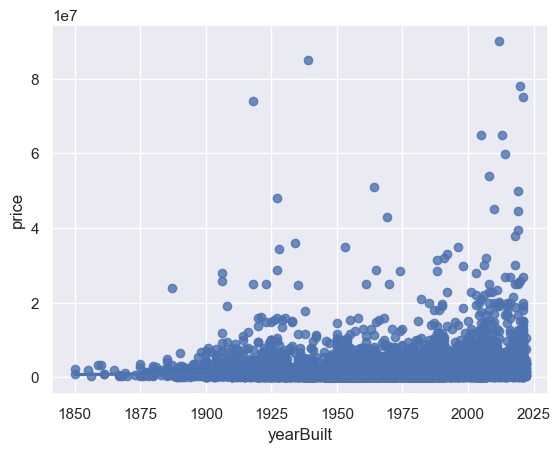

In [135]:
normal_year_built = clean_dataset[(clean_dataset['yearBuilt'] > 0) & (clean_dataset['yearBuilt'] < 2025)]
sns.regplot(x=normal_year_built['yearBuilt'],y=normal_year_built['price'])

<Axes: xlabel='zipcode', ylabel='price'>

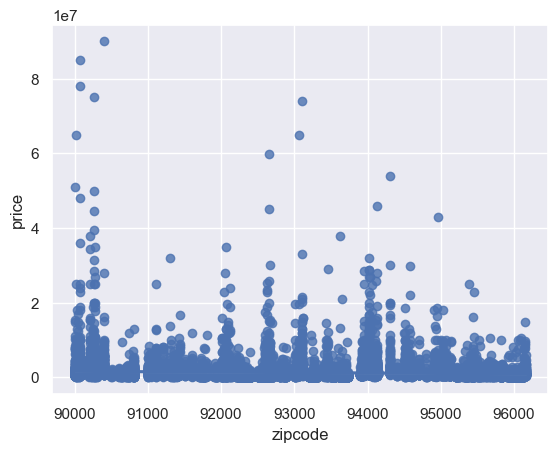

In [136]:
sns.regplot(x=clean_dataset['zipcode'],y=clean_dataset['price'])

In [137]:
def remove_outliers(df,column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

<Axes: xlabel='livingAreaValue', ylabel='price'>

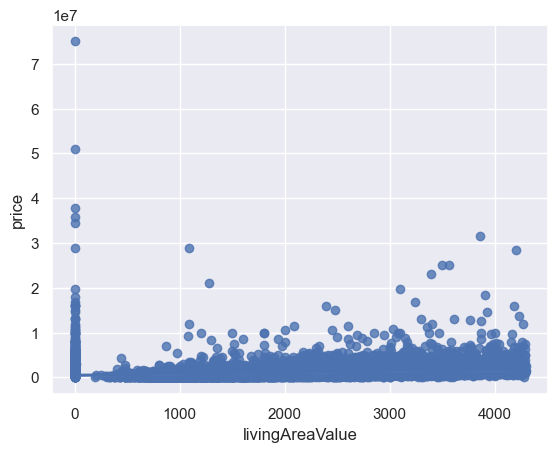

In [138]:
normal_living_area = remove_outliers(clean_dataset,'livingAreaValue')
sns.regplot(x=normal_living_area['livingAreaValue'],y=normal_living_area['price'])

<Axes: xlabel='bathrooms', ylabel='price'>

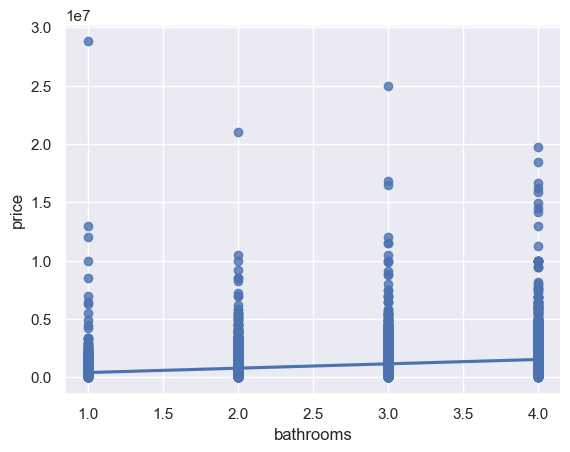

In [139]:
normal_bathroom = remove_outliers(clean_dataset,'bathrooms')
sns.regplot(x=normal_bathroom['bathrooms'],y=normal_bathroom['price'])

<Axes: xlabel='bedrooms', ylabel='price'>

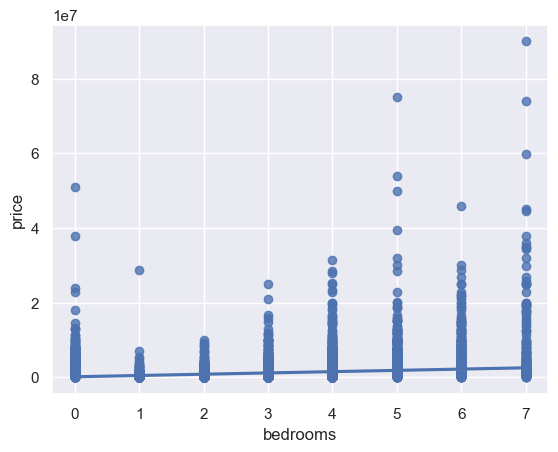

In [140]:
normal_bedroom = remove_outliers(clean_dataset,'bedrooms')
sns.regplot(x=normal_bedroom['bedrooms'],y=normal_bedroom['price'])

<Axes: xlabel='buildingArea', ylabel='price'>

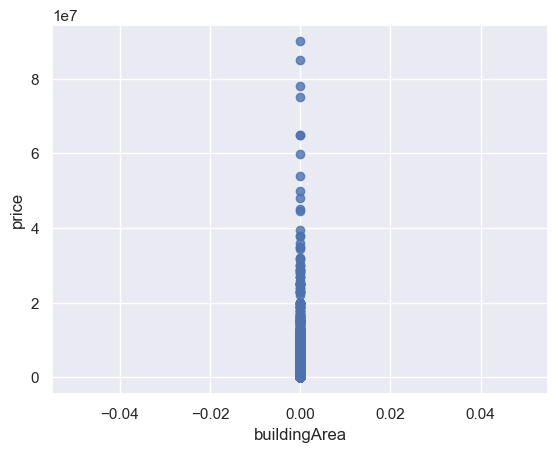

In [141]:
normal_building_area = remove_outliers(clean_dataset,'buildingArea')
sns.regplot(x=normal_building_area['buildingArea'],y=normal_building_area['price'])


<Axes: xlabel='garageSpaces', ylabel='price'>

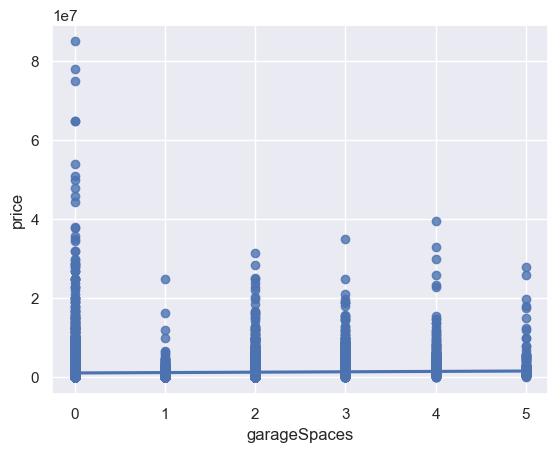

In [142]:
normal_garages = remove_outliers(clean_dataset,'garageSpaces')
sns.regplot(data = normal_garages, x='garageSpaces',y='price')

<Axes: xlabel='level', ylabel='price'>

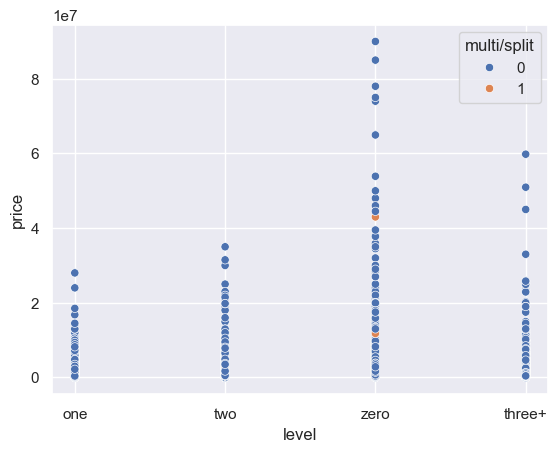

In [143]:
sns.scatterplot(x=clean_dataset['level'],y=clean_dataset['price'],hue = clean_dataset['multi/split'])

<Axes: xlabel='season_posted', ylabel='price'>

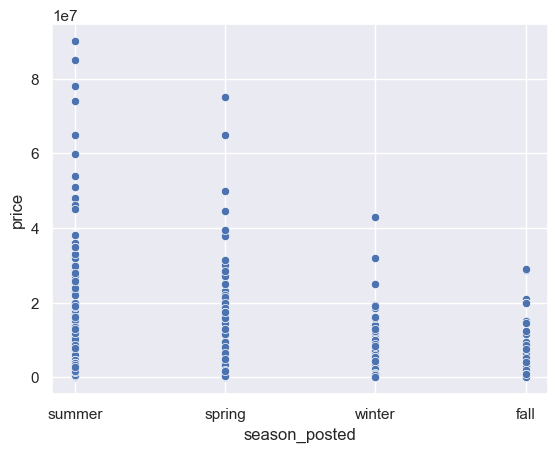

In [144]:
sns.scatterplot(x=clean_dataset['season_posted'],y=clean_dataset['price'])

<Axes: xlabel='homeType', ylabel='price'>

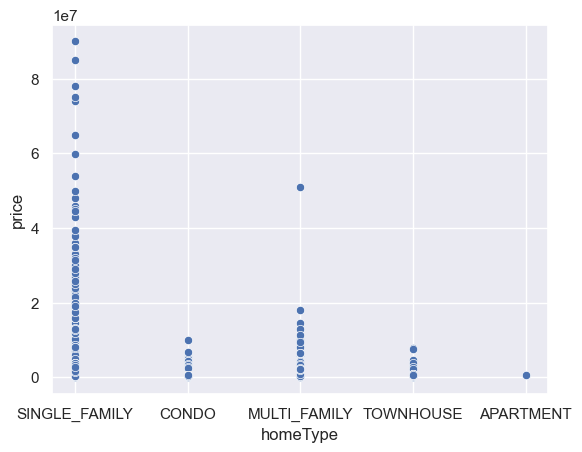

In [145]:
sns.scatterplot(x=clean_dataset['homeType'],y=clean_dataset['price'])

<Axes: xlabel='pool', ylabel='price'>

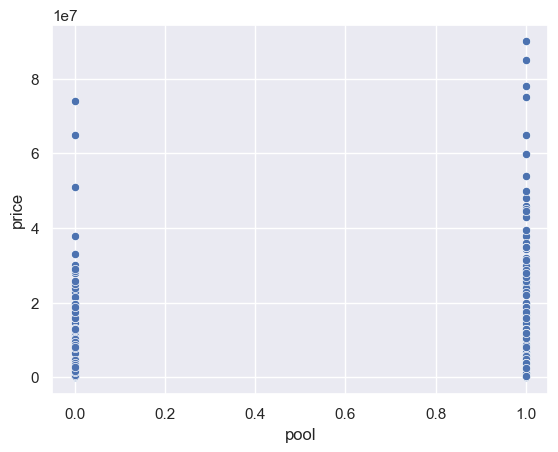

In [146]:
sns.scatterplot(x=clean_dataset['pool'],y=clean_dataset['price'])

<Axes: xlabel='spa', ylabel='price'>

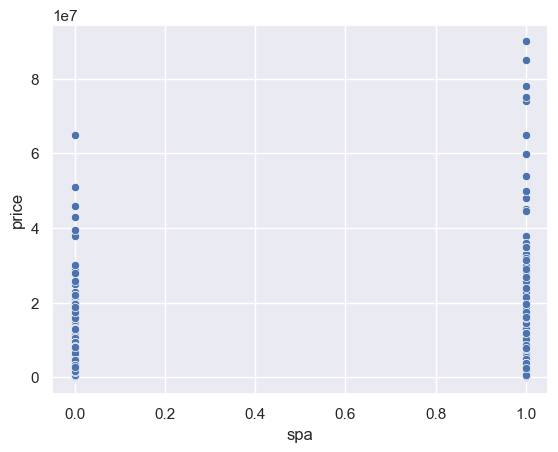

In [147]:
sns.scatterplot(x=clean_dataset['spa'],y=clean_dataset['price'])

<Axes: xlabel='isNewConstruction', ylabel='price'>

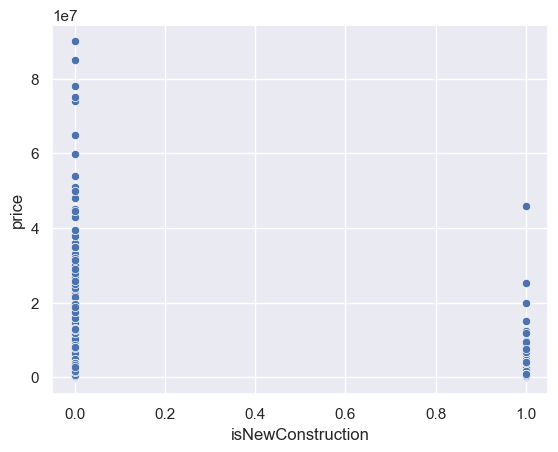

In [148]:
sns.scatterplot(x=clean_dataset['isNewConstruction'],y=clean_dataset['price'])

<Axes: xlabel='hasPetsAllowed', ylabel='price'>

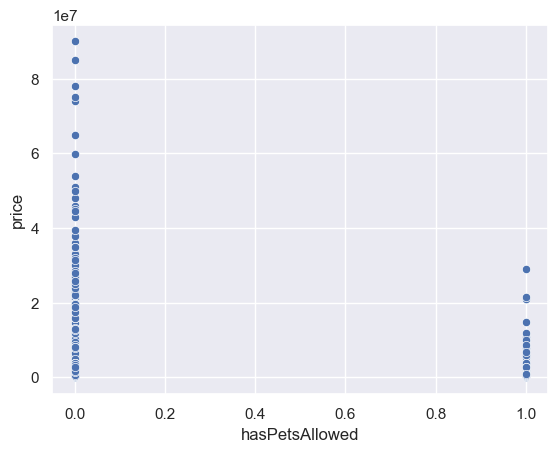

In [149]:
sns.scatterplot(x=clean_dataset['hasPetsAllowed'],y=clean_dataset['price'])

## Data analysis

### Ordinal encoding categorical columns

In [150]:
# from sklearn.preprocessing import OrdinalEncoder

# cat_columns = clean_dataset.select_dtypes(include = 'object').columns

# ordinal_encoder = OrdinalEncoder()
# clean_dataset[cat_columns] = ordinal_encoder.fit_transform(clean_dataset[cat_columns])

In [151]:
# correlations = clean_dataset.corr()
# correlations = correlations.round(3)
# correlations.iloc[:,:13]

In [152]:
# correlations.iloc[:,13:]